# 1. Create Dataset and Dataloader

In [1]:
# CHECK CUDA
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla T4


In [2]:
from torch.utils import data
from PIL import Image
import os
import sys
import numpy as np
from natsort import natsorted
import shutil
import glob
import albumentations as albu

import cv2
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('../')

In [6]:
DATA_DIR = "../data"

## Load data

In [7]:
train_img_list = natsorted(glob.glob(DATA_DIR+"/train/img/*"))
train_anno_list = natsorted(glob.glob(DATA_DIR+"/train/anno/*"))

test_img_list = natsorted(glob.glob(DATA_DIR+"/test/img/*"))
test_anno_list = natsorted(glob.glob(DATA_DIR+"/test/anno/*"))

val_img_list = natsorted(glob.glob(DATA_DIR+"/valid/img/*"))
val_anno_list = natsorted(glob.glob(DATA_DIR+"/valid/anno/*"))

In [8]:
# Confirm loading all data
len(train_anno_list)+len(test_anno_list)+len(val_anno_list)

5495

In [9]:
# At the first time we run binirize processing for learning model.
# Please change True if it is firt time to run.
FIRST_TIME = False

In [10]:
if FIRST_TIME:
    # training
    for i in range(len(train_anno_list)):
        im = Image.open(train_anno_list[i])
        im_list = np.asarray(im)
        X = im_list
        Y = np.where(X>1,1,X)
        pil_img = Image.fromarray(Y)
        pil_img.save(train_anno_list[i])

In [11]:
if FIRST_TIME:
    # validation
    for i in range(len(val_anno_list)):
        im = Image.open(val_anno_list[i])
        im_list = np.asarray(im)
        X = im_list
        Y = np.where(X>1,1,X)
        pil_img = Image.fromarray(Y)
        pil_img.save(val_anno_list[i])

In [12]:
if FIRST_TIME:
    # test
    for i in range(len(test_anno_list)):
        im = Image.open(test_anno_list[i])
        im_list = np.asarray(im)
        X = im_list
        Y = np.where(X>1,1,X)
        pil_img = Image.fromarray(Y)
        pil_img.save(test_anno_list[i])

# 2. Define Dataset
Dataset includes some kind of pre-processing like augumentation
See also: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [13]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['unlabelled', 'billboard'] #変更

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_fps = images_dir
        self.masks_fps = masks_dir

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask

    def __len__(self):
        return len(self.images_fps)

In [14]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [15]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [
        albu.Resize(480, 856, p=1),
        albu.HorizontalFlip(p=0.5),
        albu.Downscale(scale_max=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0.5, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),

        #albu.IAAAdditiveGaussianNoise(p=0.1),
        albu.IAAPerspective(p=0.2),
        albu.RandomContrast(p=1),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(480, 856, p=1),
        albu.PadIfNeeded(480, 384)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

## Confirm Dataset work

(480, 856, 3)


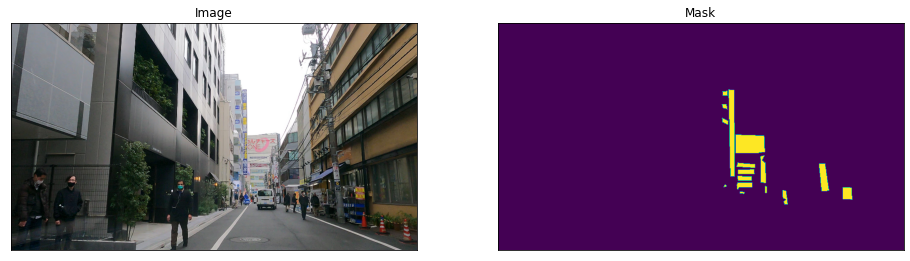

In [17]:
augmented_dataset = Dataset(
    val_img_list, 
    val_anno_list, 
    augmentation=get_validation_augmentation(), 
    classes=['billboard'],
)

# same image with different random transforms
for i in range(1):
    image, mask = augmented_dataset[2]
    print(image.shape)
    visualize(image=image, mask=mask.squeeze(-1))

(480, 856, 3)


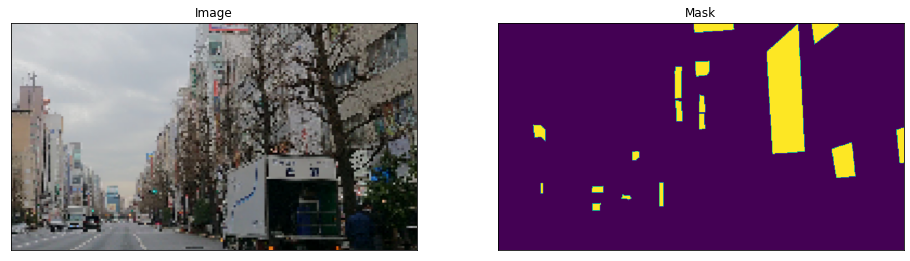

In [18]:
augmented_dataset = Dataset(
    train_img_list, 
    train_anno_list, 
    augmentation=get_training_augmentation(), 
    classes=['billboard'],
)

# same image with different random transforms
for i in range(1):
    image, mask = augmented_dataset[2]
    print(image.shape)
    visualize(image=image, mask=mask.squeeze(-1))

# 3. Train

In [19]:
# On jupyterlab, we met an error about tqdm, so please download below file before start running this cell.
# !wget -p /home/ubuntu/.cache/torch/hub/checkpoints/ https://download.pytorch.org/models/resnet50-19c8e357.pth

In [20]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['billboard']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [21]:
train_dataset = Dataset(
    train_img_list, 
    train_anno_list, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    val_img_list, 
    val_anno_list, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)

In [22]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [23]:
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [24]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [25]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [26]:
max_score = 0

#Set up array for visualize train accurascy, train loss, val_accuracy, val_loss.
x_epoch_data = []
train_dice_loss = []
train_iou_score = []
valid_dice_loss = []
valid_iou_score = []


for i in range(0, 40):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_iou_score.append(train_logs['iou_score'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_iou_score.append(valid_logs['iou_score'])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_Unet_resnet50.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 330/330 [03:54<00:00,  1.40it/s, dice_loss - 0.3954, iou_score - 0.466] 
Model saved!

Epoch: 1
valid: 100%|██████████| 330/330 [03:55<00:00,  1.40it/s, dice_loss - 0.3342, iou_score - 0.521] 
Model saved!

Epoch: 2
valid: 100%|██████████| 330/330 [03:55<00:00,  1.40it/s, dice_loss - 0.3177, iou_score - 0.5384]
Model saved!

Epoch: 3
valid: 100%|██████████| 330/330 [03:55<00:00,  1.40it/s, dice_loss - 0.3018, iou_score - 0.5531]
Model saved!

Epoch: 4
valid: 100%|██████████| 330/330 [03:55<00:00,  1.40it/s, dice_loss - 0.3024, iou_score - 0.5541]
Model saved!

Epoch: 5
valid: 100%|██████████| 330/330 [03:55<00:00,  1.40it/s, dice_loss - 0.2912, iou_score - 0.5672]
Model saved!

Epoch: 6
valid: 100%|██████████| 330/330 [03:52<00:00,  1.42it/s, dice_loss - 0.2934, iou_score - 0.5647]

Epoch: 7
valid: 100%|██████████| 330/330 [03:55<00:00,  1.40it/s, dice_loss - 0.2818, iou_score - 0.5794]
Model saved!

Epoch: 8
valid: 100%|██████████| 330/330 [03:54<00:0

## Visualize loss and iou

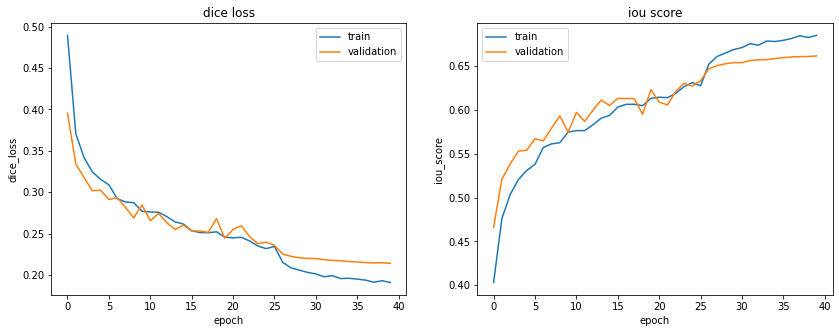

In [27]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train') 
line2, = ax1.plot(x_epoch_data,valid_dice_loss,label='validation')
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
line1, = ax2.plot(x_epoch_data,train_iou_score,label='train')
line2, = ax2.plot(x_epoch_data,valid_iou_score,label='validation') 
ax2.set_title("iou score")
ax2.set_xlabel('epoch')
ax2.set_ylabel('iou_score')
ax2.legend(loc='upper left')

plt.show()

In [28]:
# load best saved checkpoint
best_model = torch.load('./best_model_Unet_resnet50.pth')

best_model

DeepLabV3(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

# 4. Test

In [29]:
# create test dataset
test_dataset = Dataset(
    test_img_list,
    test_anno_list,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 1099/1099 [06:48<00:00,  2.69it/s, dice_loss - 0.2449, iou_score - 0.6317]


In [30]:
# test dataset without transformations for image visualization
test_dataset_vis2 = Dataset(
    test_img_list, test_anno_list,
    augmentation=get_validation_augmentation(), 
    classes=CLASSES,
)

(3, 480, 856)
torch.Size([1, 3, 480, 856])


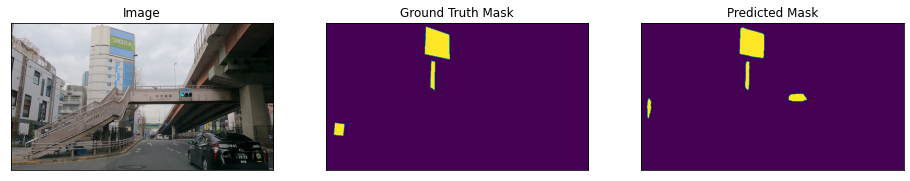

(3, 480, 856)
torch.Size([1, 3, 480, 856])


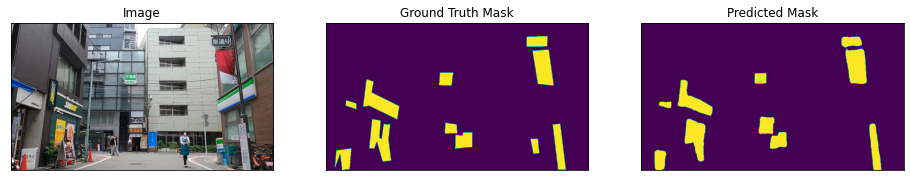

(3, 480, 856)
torch.Size([1, 3, 480, 856])


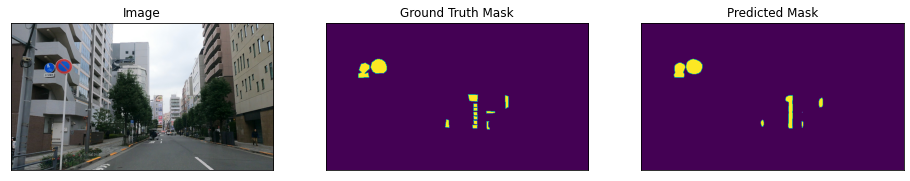

(3, 480, 856)
torch.Size([1, 3, 480, 856])


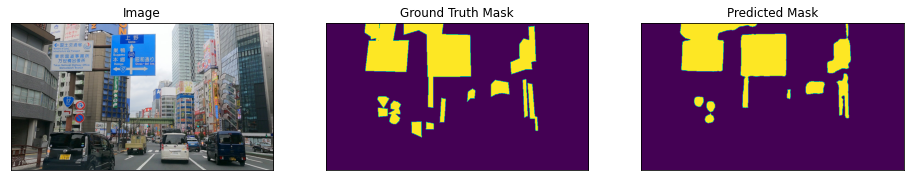

(3, 480, 856)
torch.Size([1, 3, 480, 856])


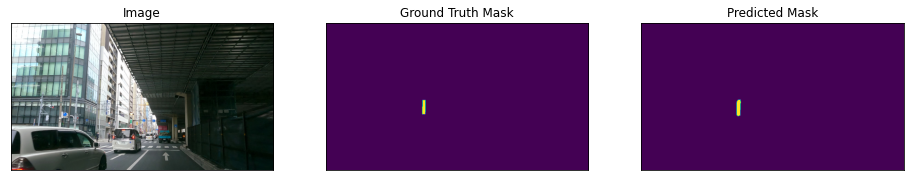

(3, 480, 856)
torch.Size([1, 3, 480, 856])


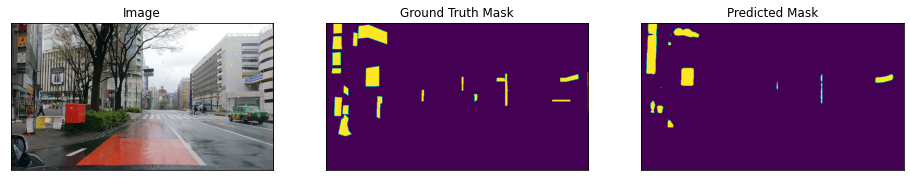

(3, 480, 856)
torch.Size([1, 3, 480, 856])


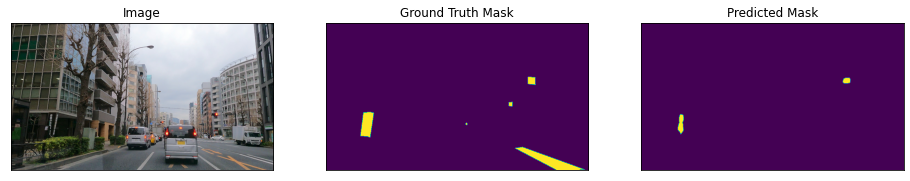

(3, 480, 856)
torch.Size([1, 3, 480, 856])


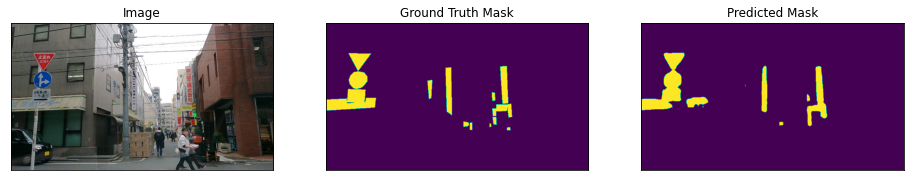

(3, 480, 856)
torch.Size([1, 3, 480, 856])


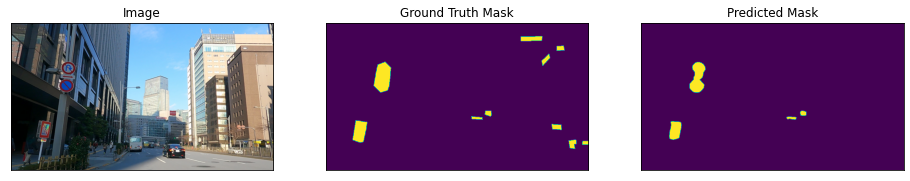

(3, 480, 856)
torch.Size([1, 3, 480, 856])


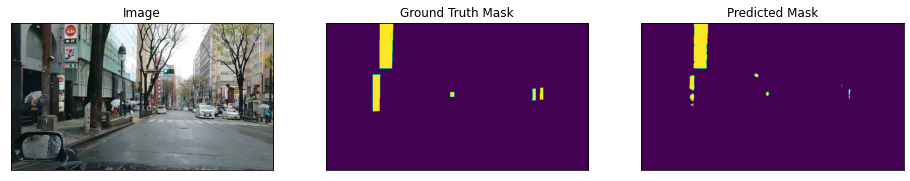

In [36]:
for i in range(10):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis2[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    print(image.shape)

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    print(x_tensor.shape)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )